In [1]:
import pandas as pd
import numpy as np
import sqlite3

from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.metrics import roc_auc_score, accuracy_score, roc_curve, auc, classification_report, confusion_matrix
from sklearn.neighbors import KNeighborsClassifier
from tqdm import tqdm

from sklearn.feature_extraction.text import CountVectorizer,TfidfVectorizer
from gensim.models import Word2Vec

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

import warnings
warnings.filterwarnings("ignore")

#### Loading previously cleaned preprocessed data (Only Considering Cleaned_Text & Score Variables) <a href="https://github.com/ParveshDhawan/Amazon_Review_Case_Study/blob/main/Amazon%20Fine%20Food%20Reviews%20Analysis_Word_Embedding_TSNE.ipynb"> LINK </a>


In [2]:
# Load Data 
conn = sqlite3.connect('../data/Preprocessed_Data.sqlite')
df = pd.read_sql_query("Select Cleaned_Text, Score from Reviews order by Time desc limit 50000;",conn)
# df = pd.read_sql_query("Select * from Reviews order by Time desc limit 100000;",conn)
df['Score'] = df.Score.apply(lambda x : 1 if x == 'positive' else -1)
df.head()

,Cleaned_Text,Score
0,love faucet husband installed one old house cu...,1
1,gone treat dinner treat dogs work run chance l...,1
2,no instructions provided trap would not open t...,-1
3,well built mole trap works great set correctly...,1
4,got give goodie bag holidays couple extras cou...,1


### Splitting Data into Train, Validation & Test Set

In [3]:
# Splitting Data
X_train,X_test,Y_train,Y_test = train_test_split(df.Cleaned_Text.values, df.Score.values, test_size=0.2, random_state=143, shuffle=False)
X_train,X_val,Y_train,Y_val = train_test_split(X_train, Y_train, test_size=0.2, random_state=143, shuffle=False)
print(X_train.shape, X_val.shape, X_test.shape)

(32000,) (8000,) (10000,)


> - #### Helper Functions

In [4]:
def check_optimal_k(x_train,x_val,y_train, y_val, Model_algorithm):
    train_auc = []
    val_auc = []
    K = list(range(1, 50, 4))
    for k in tqdm(K): # 1, 5, 9 ...49
        classifier = KNeighborsClassifier(n_neighbors = k, algorithm= Model_algorithm, n_jobs=-1).fit(x_train, y_train)
        Y_train_pred = classifier.predict_proba(x_train)[:,1]
        train_auc.append(roc_auc_score(y_train, Y_train_pred))
        
        Y_val_pred = classifier.predict_proba(x_val)[:,1]
        val_auc.append(roc_auc_score(y_val, Y_val_pred))
        # cross_val_score(neigh, X_val_bow, Y_val, cv=10, scoring='roc_auc').mean()

    optimal_k= K[val_auc.index(max(val_auc))]
    plt.figure(figsize=(12, 10))
    plt.plot(K, train_auc, label='Train AUC')
    plt.scatter(K, train_auc, label='train_K')
    plt.plot(K, val_auc, label='Val AUC')
    plt.scatter(K, val_auc, label='val_K')
    plt.legend()
    plt.xlabel("K: hyperparameter")
    plt.ylabel("AUC")
    plt.title(f"ERROR PLOTS - KNN Using (algorithm = {Model_algorithm})")
    plt.show()
    print('optimal K for which Val auc is maximum : ',optimal_k)
    return optimal_k
    
def optimal_value_model(optimal_k,Model_algorithm, x_train, y_train, x_test, y_test):
    optimal_model = KNeighborsClassifier(n_neighbors = optimal_k,
                                         algorithm = Model_algorithm,
                                         n_jobs = -1).fit(x_train, y_train)
    prediction = optimal_model.predict(x_test)

    train_fpr, train_tpr, thresholds = roc_curve(y_train, optimal_model.predict_proba(x_train)[:,1])
    test_fpr, test_tpr, thresholds = roc_curve(y_test, optimal_model.predict_proba(x_test)[:,1])
    
    Final_AUC_Score_train = auc(train_fpr, train_tpr)
    Final_AUC_Score_test = auc(test_fpr, test_tpr)
    
    plt.figure(figsize=(12, 10))
    plt.plot(train_fpr, train_tpr, label="train AUC ="+str(auc(train_fpr, train_tpr)))
    plt.plot(test_fpr, test_tpr, label="test AUC ="+str(auc(test_fpr, test_tpr)))
    plt.legend()
    plt.xlabel("K: hyperparameter")
    plt.ylabel("AUC")
    plt.title(f"ERROR PLOTS for KNN using (algorithm = {Model_algorithm}) and NN value = {optimal_k}")
    plt.show()
    
    print(classification_report(y_test, prediction))    
    return [Final_AUC_Score_train, Final_AUC_Score_test, optimal_k, Model_algorithm],optimal_model


def confusion_matrix_plot(optimal_model,x_train, y_train, x_test, y_test):
    conf_matrix_train = confusion_matrix(y_train,optimal_model.predict(x_train))
    conf_matrix_test = confusion_matrix(y_test,optimal_model.predict(x_test))
    class_label =[-1,1]

    df_conf_matrix_train = pd.DataFrame(conf_matrix_train, index=class_label, columns = class_label)
    df_conf_matrix_test = pd.DataFrame(conf_matrix_test, index = class_label, columns = class_label)

    fig, ax = plt.subplots(1,2,figsize=(12,5))
    sns.heatmap(df_conf_matrix_train, annot=True, fmt='d', cmap="YlGnBu", ax=ax[1])
    ax[1].set_title("confusion_matrix for train")
    ax[1].set(xlabel='Predicted', ylabel='Actual')

    sns.heatmap(df_conf_matrix_test, annot=True, fmt='d', cmap="YlGnBu", ax=ax[0])
    ax[0].set_title("confusion_matrix for Test")
    ax[0].set(xlabel='Predicted', ylabel='Actual')
    plt.show()

### Apply KNN - Brute Force
>- ##### BOW (Bag of Words)

  0%|          | 0/13 [00:00<?, ?it/s]

(32000, 33794) (8000, 33794) (10000, 33794)


100%|██████████| 13/13 [21:16<00:00, 98.19s/it] 


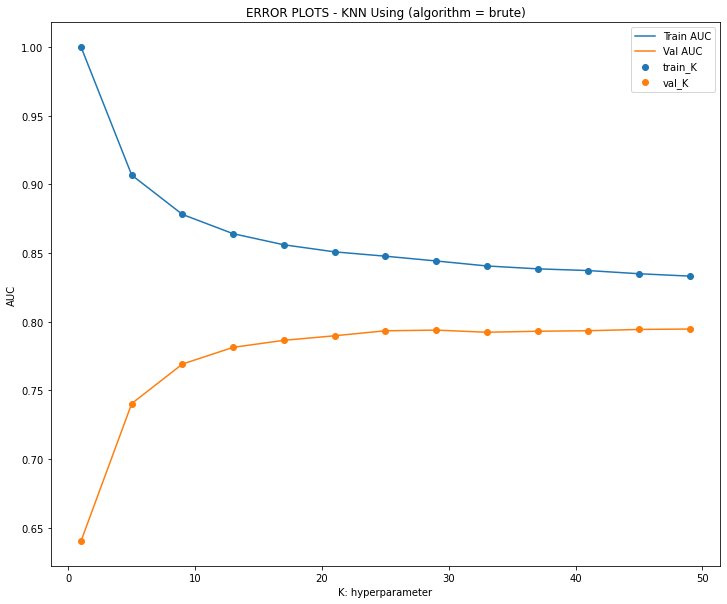

optimal K for which Val auc is maximum :  49


In [5]:
bow_vectorizer = CountVectorizer().fit(X_train)
X_train_bow = bow_vectorizer.transform(X_train)
X_val_bow = bow_vectorizer.transform(X_val)
X_test_bow = bow_vectorizer.transform(X_test)
print(X_train_bow.shape, X_val_bow.shape, X_test_bow.shape)

optimal_k = check_optimal_k(X_train_bow,X_val_bow,Y_train, Y_val, 'brute')

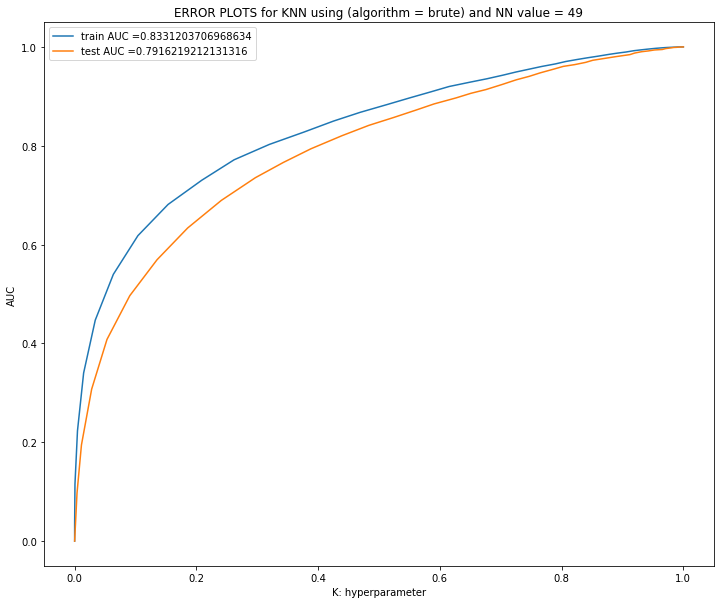

              precision    recall  f1-score   support

          -1       0.51      0.21      0.30      1788
           1       0.85      0.96      0.90      8212

    accuracy                           0.82     10000
   macro avg       0.68      0.58      0.60     10000
weighted avg       0.79      0.82      0.79     10000



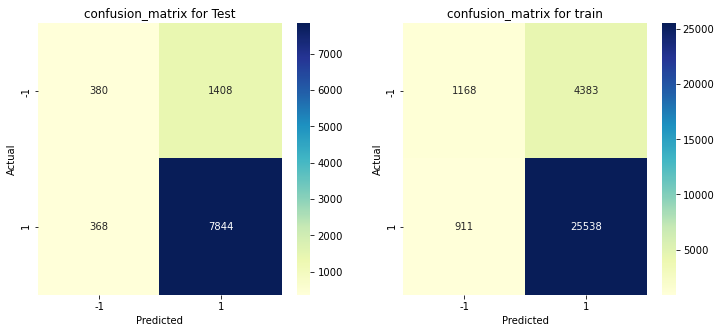

In [6]:
AUC_BF_BOW,model = optimal_value_model(optimal_k, 'brute', X_train_bow, Y_train, X_test_bow, Y_test)
confusion_matrix_plot(model,X_train_bow, Y_train, X_test_bow, Y_test)

>- ##### TF-IDF 

  0%|          | 0/13 [00:00<?, ?it/s]

(32000, 18074) (8000, 18074) (10000, 18074)


100%|██████████| 13/13 [22:55<00:00, 105.79s/it]


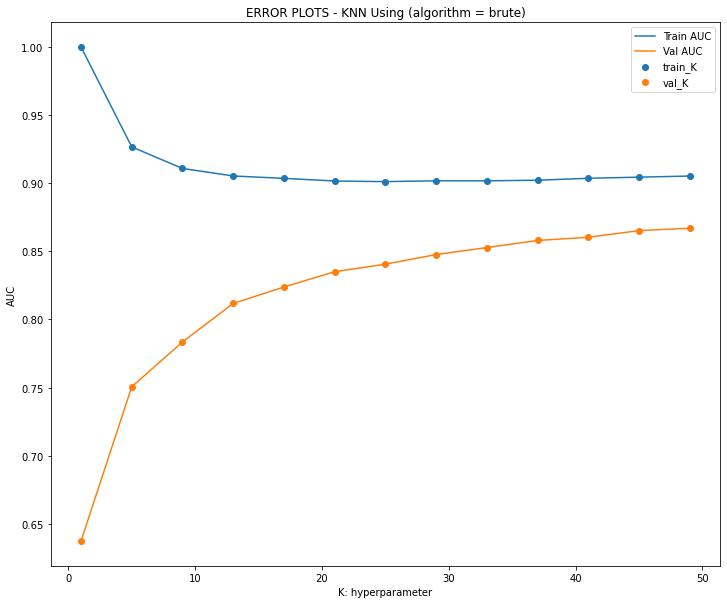

optimal K for which Val auc is maximum :  49


In [7]:
Tfidf_vect = TfidfVectorizer(ngram_range=(1,2), min_df=10).fit(X_train)
Tfidf_train = Tfidf_vect.transform(X_train)
Tfidf_val = Tfidf_vect.transform(X_val)
Tfidf_test = Tfidf_vect.transform(X_test)
print(Tfidf_train.shape, Tfidf_val.shape, Tfidf_test.shape)

optimal_k = check_optimal_k(Tfidf_train,Tfidf_val,Y_train, Y_val, 'brute')

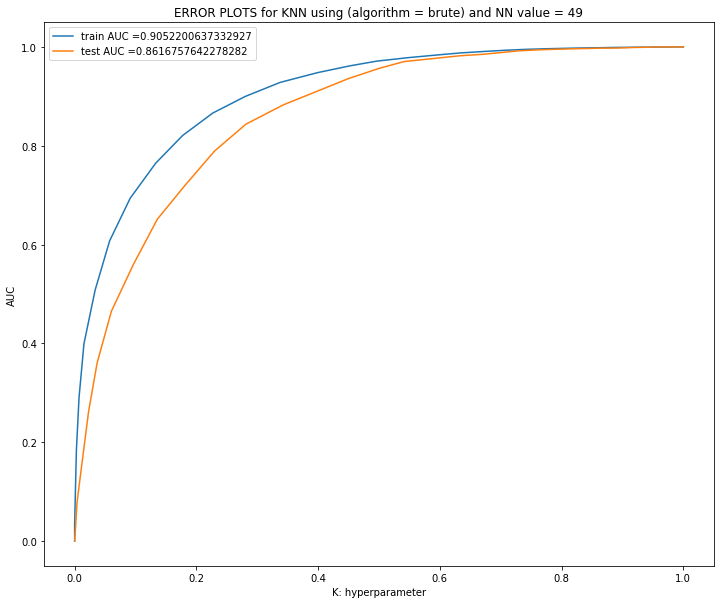

              precision    recall  f1-score   support

          -1       0.92      0.16      0.27      1788
           1       0.84      1.00      0.91      8212

    accuracy                           0.85     10000
   macro avg       0.88      0.58      0.59     10000
weighted avg       0.86      0.85      0.80     10000



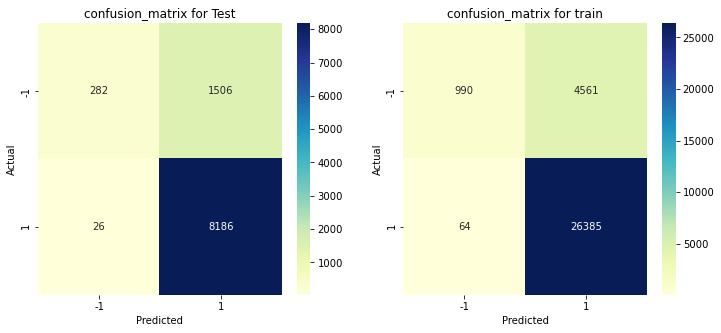

In [8]:
AUC_BF_Tfidf,model = optimal_value_model(optimal_k, 'brute', Tfidf_train, Y_train, Tfidf_test, Y_test)
confusion_matrix_plot(model,Tfidf_train, Y_train, Tfidf_test, Y_test)

>- ##### Average Word 2 Vec

  0%|          | 0/32000 [00:00<?, ?it/s]

len of list of words : 10867


100%|██████████| 13/13 [21:19<00:00, 98.42s/it] 


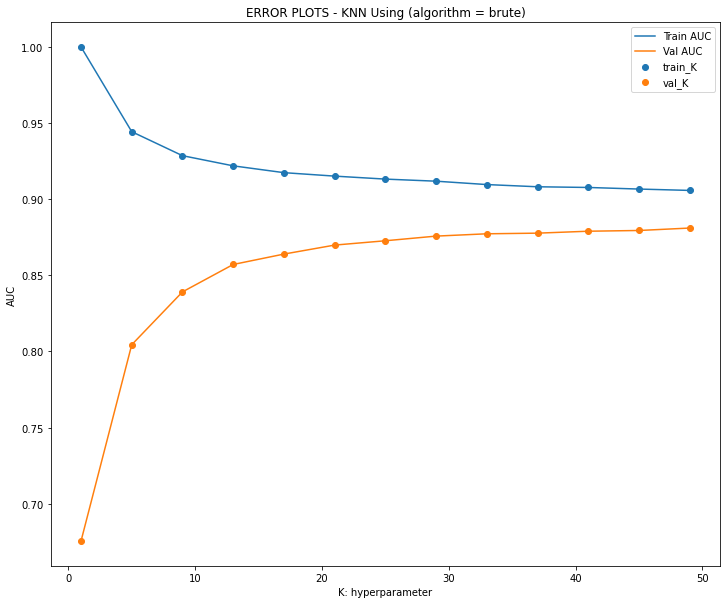

optimal K for which Val auc is maximum :  49


In [9]:
def avg_w2v(data, model):
    list_of_sentance = [i.split() for i in data]
    word_list = list(model.wv.key_to_index.keys())
    sentance_vectors = []
    for sent in tqdm(list_of_sentance):
        sent_vec = np.zeros(50)
        cnt_words = 0
        for word in sent:
            if word in word_list:
                vec = model.wv[word]
                sent_vec += vec
                cnt_words += 1
        if cnt_words != 0:
            sent_vec /= cnt_words
        sentance_vectors.append(sent_vec)
    return sentance_vectors

list_of_sentance = [i.split() for i in X_train]
w2v_model = Word2Vec(list_of_sentance, min_count=5, vector_size=50, workers=4)
print(f'len of list of words : {len(list(w2v_model.wv.key_to_index))}')

W2V_train = avg_w2v(X_train, w2v_model)
W2V_val = avg_w2v(X_val, w2v_model)
W2V_test = avg_w2v(X_test, w2v_model)

optimal_k = check_optimal_k(W2V_train,W2V_val,Y_train, Y_val, 'brute')

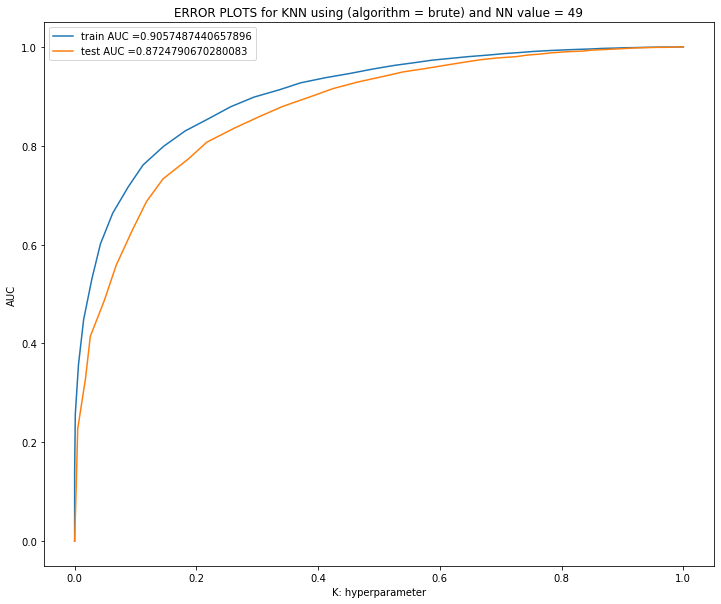

              precision    recall  f1-score   support

          -1       0.75      0.27      0.40      1788
           1       0.86      0.98      0.92      8212

    accuracy                           0.85     10000
   macro avg       0.81      0.63      0.66     10000
weighted avg       0.84      0.85      0.82     10000



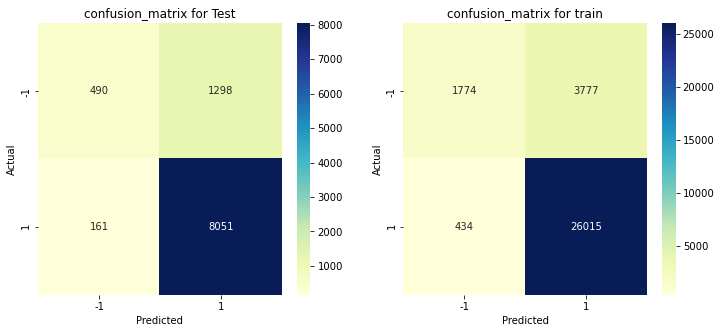

In [10]:
AUC_BF_AVGW2V,model = optimal_value_model(optimal_k, 'brute', W2V_train, Y_train, W2V_test, Y_test)
confusion_matrix_plot(model, W2V_train, Y_train, W2V_test, Y_test)

>- ##### TfiDF Word 2 Vec

100%|██████████| 13/13 [23:09<00:00, 106.88s/it]


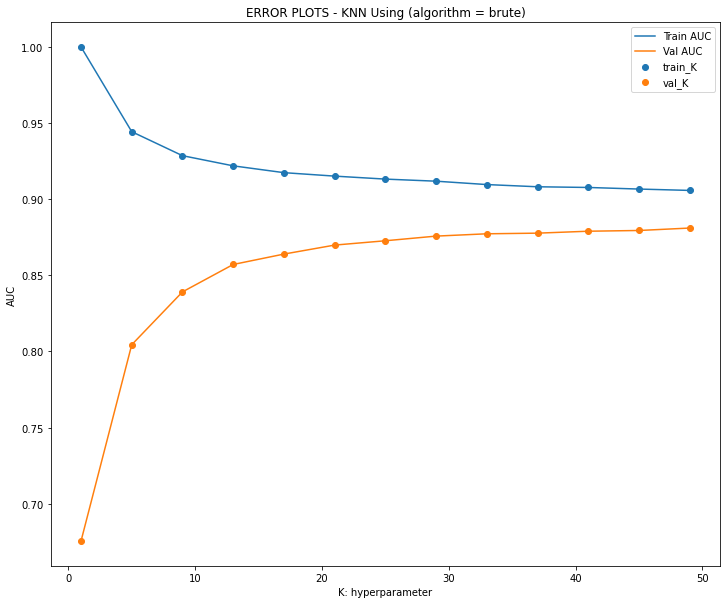

optimal K for which Val auc is maximum :  49


In [11]:
tfidf_model = TfidfVectorizer().fit(X_train)
tfidf_dict = dict(zip(tfidf_model.get_feature_names(), list(tfidf_model.idf_)))

def tfidf_w2v(data, model):
    list_of_sentance = [i.split() for i in data]
    word_list = list(model.wv.key_to_index.keys())
    sentance_vectors = []
    for sent in tqdm(list_of_sentance):
        sent_vec = np.zeros(50)
        weighted_sum = 0
        for word in sent:
            if word in word_list and word in tfidf_dict:
                vec = model.wv[word]
                tf_value = tfidf_dict[word]
                sent_vec += (vec * tf_value)
                weighted_sum += tf_value
        if weighted_sum > 0:
            sent_vec /= weighted_sum
        sentance_vectors.append(sent_vec)
    return sentance_vectors

tfidf_W2V_train = avg_w2v(X_train, w2v_model)
tfidf_W2V_val = avg_w2v(X_val, w2v_model)
tfidf_W2V_test = avg_w2v(X_test, w2v_model)

optimal_k = check_optimal_k(tfidf_W2V_train, tfidf_W2V_val, Y_train, Y_val, 'brute')

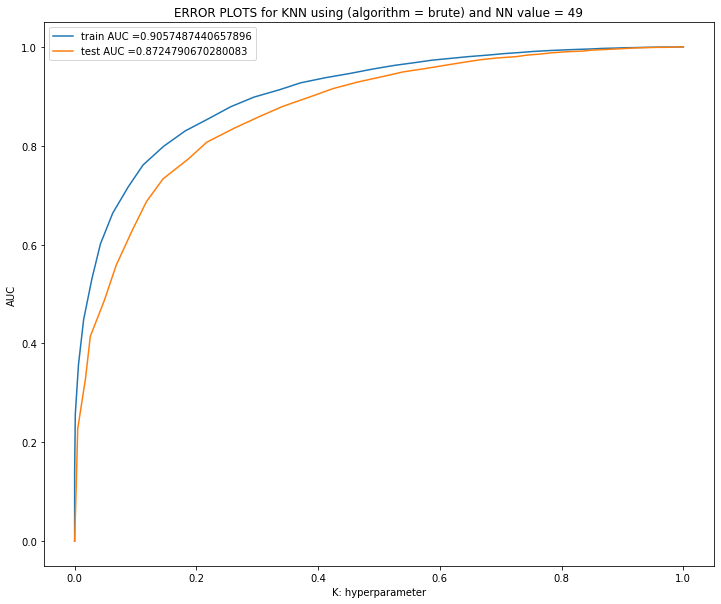

              precision    recall  f1-score   support

          -1       0.75      0.27      0.40      1788
           1       0.86      0.98      0.92      8212

    accuracy                           0.85     10000
   macro avg       0.81      0.63      0.66     10000
weighted avg       0.84      0.85      0.82     10000



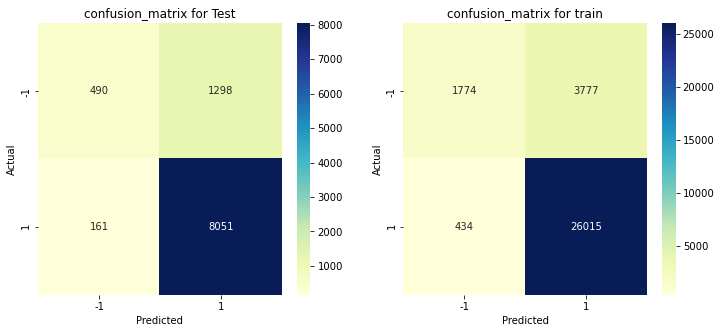

In [12]:
AUC_BF_tfidfW2V,model = optimal_value_model(optimal_k, 'brute', tfidf_W2V_train, Y_train, tfidf_W2V_test, Y_test)
confusion_matrix_plot(model, tfidf_W2V_train, Y_train, tfidf_W2V_test, Y_test)

### Apply KNN - Kd-tree Algorithm
>- ##### BOW (Bag of Words)

100%|██████████| 13/13 [24:03<00:00, 111.02s/it]


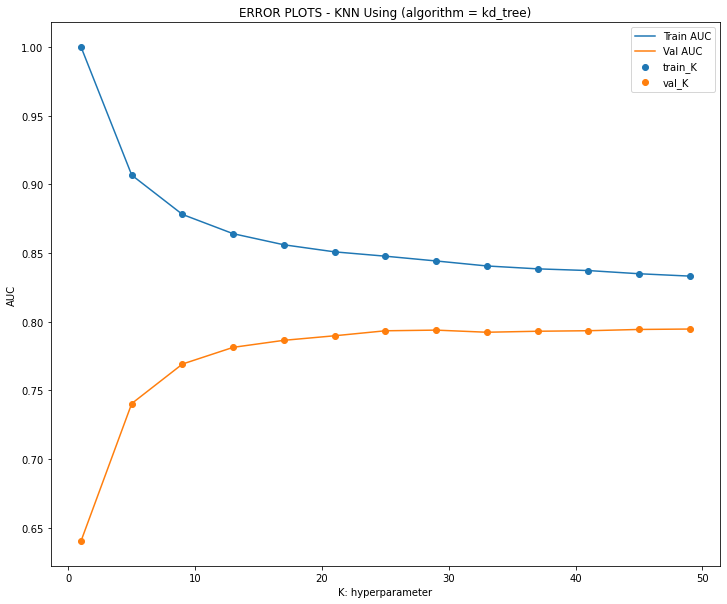

optimal K for which Val auc is maximum :  49


In [13]:
optimal_k = check_optimal_k(X_train_bow,X_val_bow,Y_train, Y_val, 'kd_tree')

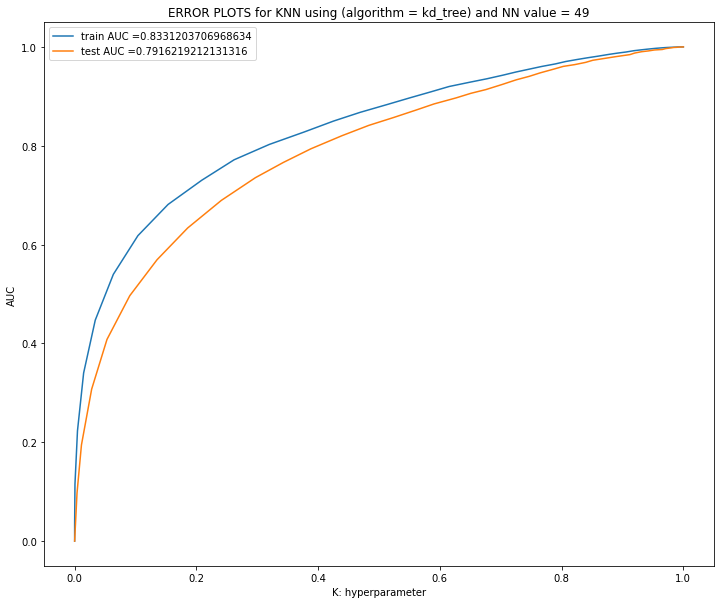

              precision    recall  f1-score   support

          -1       0.51      0.21      0.30      1788
           1       0.85      0.96      0.90      8212

    accuracy                           0.82     10000
   macro avg       0.68      0.58      0.60     10000
weighted avg       0.79      0.82      0.79     10000



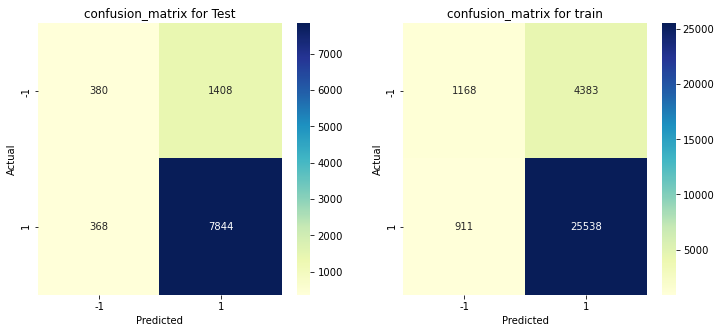

In [14]:
AUC_kd_BOW,model = optimal_value_model(optimal_k, 'kd_tree', X_train_bow, Y_train, X_test_bow, Y_test)
confusion_matrix_plot(model,X_train_bow, Y_train, X_test_bow, Y_test)

>- ##### TF-IDF 

100%|██████████| 13/13 [20:49<00:00, 96.09s/it]


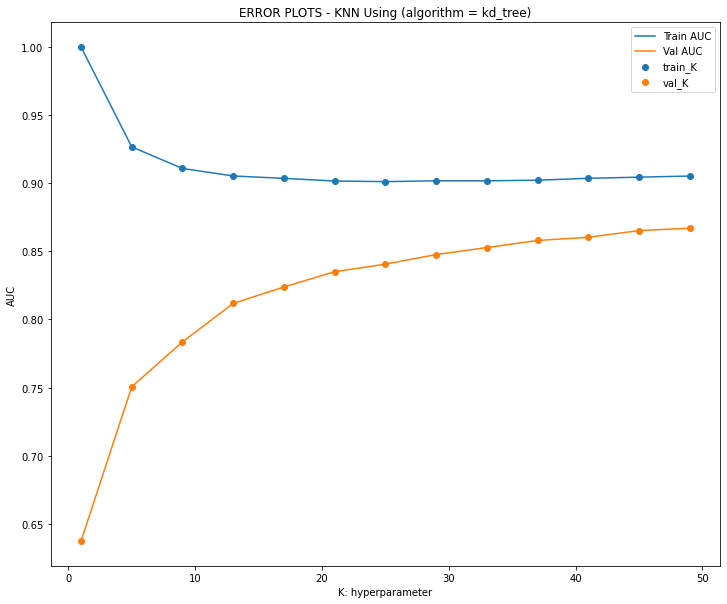

optimal K for which Val auc is maximum :  49


In [15]:
optimal_k = check_optimal_k(Tfidf_train,Tfidf_val,Y_train, Y_val, 'kd_tree')

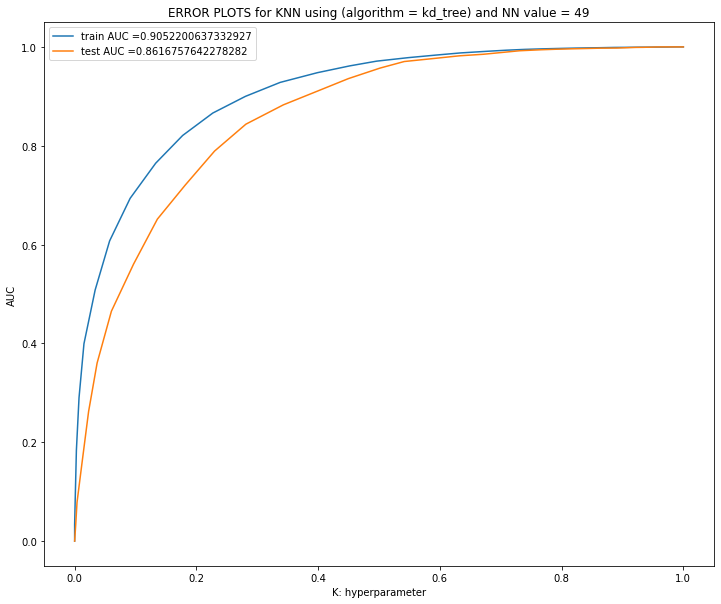

              precision    recall  f1-score   support

          -1       0.92      0.16      0.27      1788
           1       0.84      1.00      0.91      8212

    accuracy                           0.85     10000
   macro avg       0.88      0.58      0.59     10000
weighted avg       0.86      0.85      0.80     10000



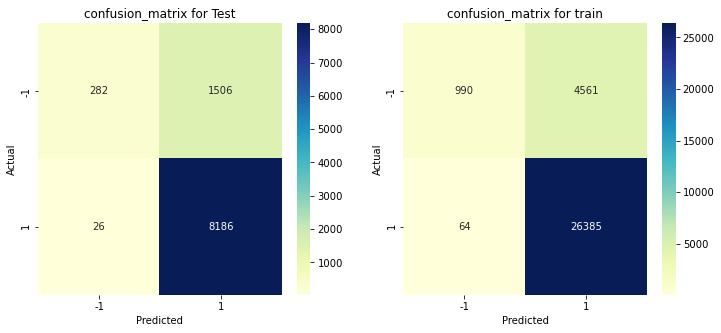

In [16]:
AUC_kd_Tfidf,model = optimal_value_model(optimal_k, 'kd_tree', Tfidf_train, Y_train, Tfidf_test, Y_test)
confusion_matrix_plot(model,Tfidf_train, Y_train, Tfidf_test, Y_test)

>- ##### Average Word 2 Vec

100%|██████████| 13/13 [21:45<00:00, 100.39s/it]


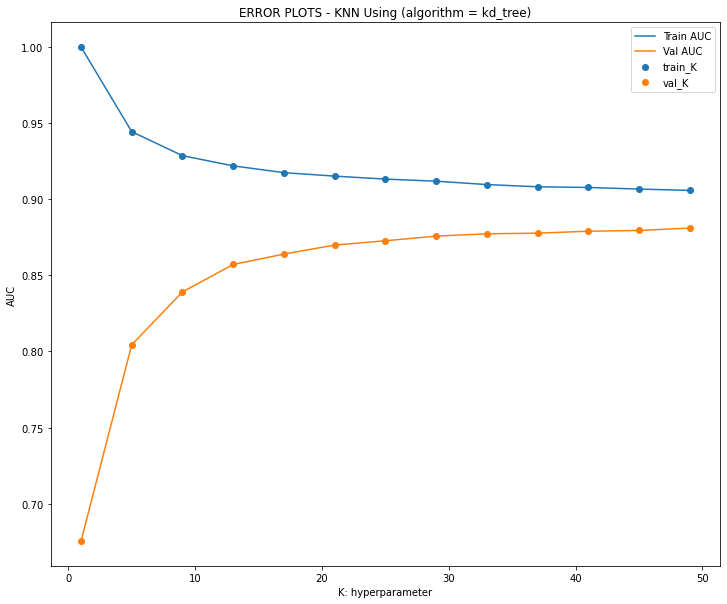

optimal K for which Val auc is maximum :  49


In [17]:
optimal_k = check_optimal_k(W2V_train,W2V_val,Y_train, Y_val, 'kd_tree')

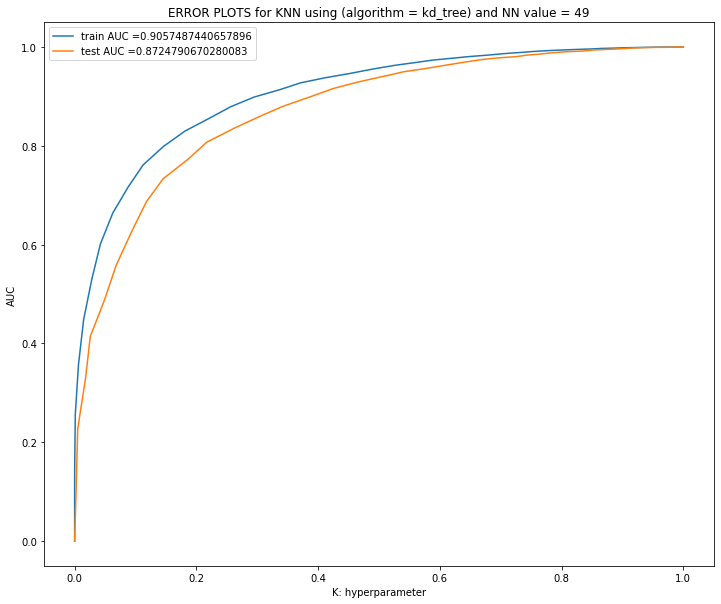

              precision    recall  f1-score   support

          -1       0.75      0.27      0.40      1788
           1       0.86      0.98      0.92      8212

    accuracy                           0.85     10000
   macro avg       0.81      0.63      0.66     10000
weighted avg       0.84      0.85      0.82     10000



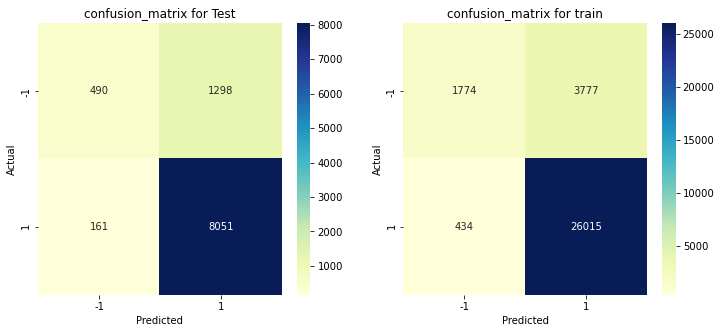

In [18]:
AUC_kd_AVGW2V,model = optimal_value_model(optimal_k, 'kd_tree', W2V_train, Y_train, W2V_test, Y_test)
confusion_matrix_plot(model, W2V_train, Y_train, W2V_test, Y_test)

>- ##### TfiDF Word 2 Vec

100%|██████████| 13/13 [21:52<00:00, 100.97s/it]


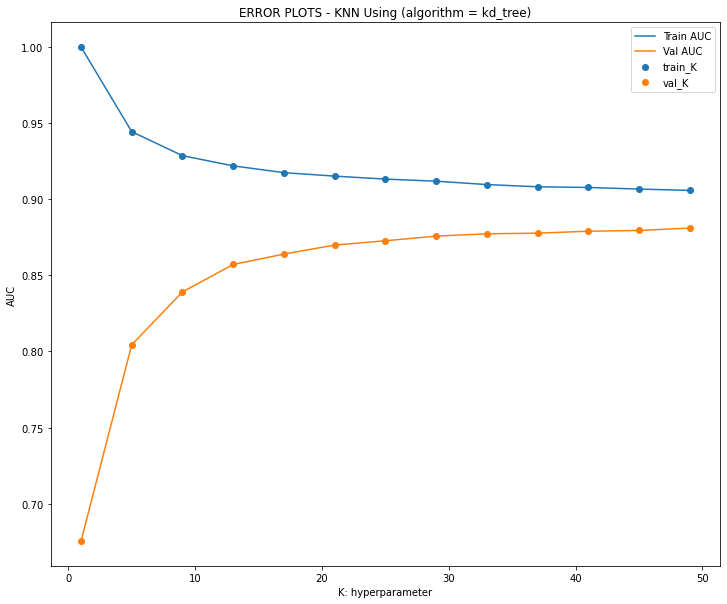

optimal K for which Val auc is maximum :  49


In [19]:
optimal_k = check_optimal_k(tfidf_W2V_train, tfidf_W2V_val, Y_train, Y_val, 'kd_tree')

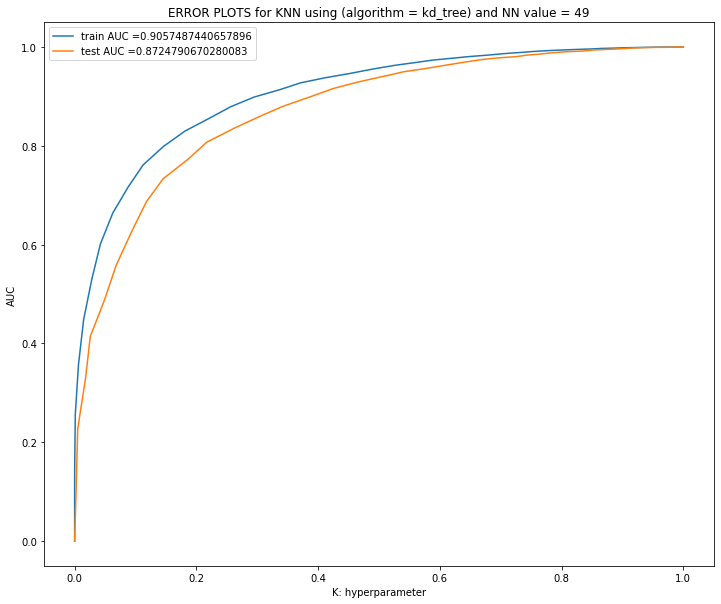

              precision    recall  f1-score   support

          -1       0.75      0.27      0.40      1788
           1       0.86      0.98      0.92      8212

    accuracy                           0.85     10000
   macro avg       0.81      0.63      0.66     10000
weighted avg       0.84      0.85      0.82     10000



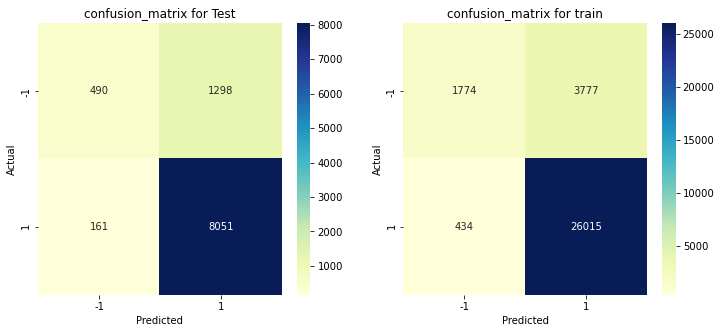

In [20]:
AUC_kd_tfidfW2V,model = optimal_value_model(optimal_k, 'kd_tree', tfidf_W2V_train, Y_train, tfidf_W2V_test, Y_test)
confusion_matrix_plot(model, tfidf_W2V_train, Y_train, tfidf_W2V_test, Y_test)

In [21]:
from prettytable import PrettyTable
comparison = PrettyTable()

comparison.field_names = ["Vectorizer", "Model", "Hyperparameter", "Train - AUC", "Test - AUC"]

comparison.add_row(["BOW",         AUC_BF_BOW[3], AUC_BF_BOW[2], np.round(float(AUC_BF_BOW[0]),3), np.round(float(AUC_BF_BOW[1]),3)])
comparison.add_row(["TFIDF",       AUC_BF_Tfidf[3], AUC_BF_Tfidf[2], np.round(float(AUC_BF_Tfidf[0]),3), np.round(float(AUC_BF_Tfidf[1]),3)])
comparison.add_row(["AVG W2V",     AUC_BF_AVGW2V[3], AUC_BF_AVGW2V[2], np.round(float(AUC_BF_AVGW2V[0]),3), np.round(float(AUC_BF_AVGW2V[1]),3)])
comparison.add_row(["Weighted W2V",AUC_BF_tfidfW2V[3], AUC_BF_tfidfW2V[2], np.round(float(AUC_BF_tfidfW2V[0]),3), np.round(float(AUC_BF_tfidfW2V[1]),3)])
comparison.add_row(["--","--","--","--","--"])
comparison.add_row(["BOW",         AUC_kd_BOW[3], AUC_kd_BOW[2], np.round(float(AUC_kd_BOW[0]),3), np.round(float(AUC_kd_BOW[1]),3)])
comparison.add_row(["TFIDF",       AUC_kd_Tfidf[3], AUC_kd_Tfidf[2], np.round(float(AUC_kd_Tfidf[0]),3), np.round(float(AUC_kd_Tfidf[1]),3)])
comparison.add_row(["AVG W2V",     AUC_kd_AVGW2V[3], AUC_kd_AVGW2V[2], np.round(float(AUC_kd_AVGW2V[0]),3), np.round(float(AUC_kd_AVGW2V[1]),3)])
comparison.add_row(["Weighted W2V",AUC_kd_tfidfW2V[3], AUC_kd_tfidfW2V[2], np.round(float(AUC_kd_tfidfW2V[0]),3), np.round(float(AUC_kd_tfidfW2V[1]),3)])
print(comparison)

+--------------+---------+----------------+-------------+------------+
|  Vectorizer  |  Model  | Hyperparameter | Train - AUC | Test - AUC |
+--------------+---------+----------------+-------------+------------+
|     BOW      |  brute  |       49       |    0.833    |   0.792    |
|    TFIDF     |  brute  |       49       |    0.905    |   0.862    |
|   AVG W2V    |  brute  |       49       |    0.906    |   0.872    |
| Weighted W2V |  brute  |       49       |    0.906    |   0.872    |
|      --      |    --   |       --       |      --     |     --     |
|     BOW      | kd_tree |       49       |    0.833    |   0.792    |
|    TFIDF     | kd_tree |       49       |    0.905    |   0.862    |
|   AVG W2V    | kd_tree |       49       |    0.906    |   0.872    |
| Weighted W2V | kd_tree |       49       |    0.906    |   0.872    |
+--------------+---------+----------------+-------------+------------+
